# Medical Cost Personal Datasets

Use a Keras sequential model with Dropout and BatchNormalization layers to predict how much health insurance premiums cost using different regression models

Dataset Link: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import optuna

from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

print(tf.__version__)
print(keras.__version__)

In [2]:
df = pd.read_csv("insurance.csv")
display(df.head(5))
display(df.info())
display(df.describe())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Delete NaN rows

In [3]:
print (df.isna().sum())
#print (df.isnull().sum())
#df.dropna(axis=0, inplace=True) #remove all rows with na's.
#df.reset_index(drop=True)
#print (df.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


# Typecast the columns to the correct type

In [4]:

# Encode smoker to bool instead of str
def smoker_encode(smoker_str):
    return smoker_str == "yes"
df["smoker"] = df["smoker"].apply(smoker_encode)

# Encode sex to bool instead of str
def sex_encode(sex_str):
    return sex_str == "female"
df["sex"] = df["sex"].apply(sex_encode)

# One hot encode categorical data
df = pd.get_dummies(df)
#df = df.astype({'sex': 'int', 'smoker': 'int', 'region': 'int'},copy=True)

display(df.head(5))
display(df.info())

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,True,27.900,0,True,16884.92400,False,False,False,True
1,18,False,33.770,1,False,1725.55230,False,False,True,False
2,28,False,33.000,3,False,4449.46200,False,False,True,False
3,33,False,22.705,0,False,21984.47061,False,True,False,False
4,32,False,28.880,0,False,3866.85520,False,True,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   bool   
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   bool   
 5   charges           1338 non-null   float64
 6   region_northeast  1338 non-null   bool   
 7   region_northwest  1338 non-null   bool   
 8   region_southeast  1338 non-null   bool   
 9   region_southwest  1338 non-null   bool   
dtypes: bool(6), float64(2), int64(2)
memory usage: 49.8 KB


None

# EDA

In [5]:
df_numerical = df[['age','bmi','children','charges']]
df_categorical = df[['sex','smoker','region_northeast','region_northwest','region_southeast','region_southwest','charges']]

<Axes: >

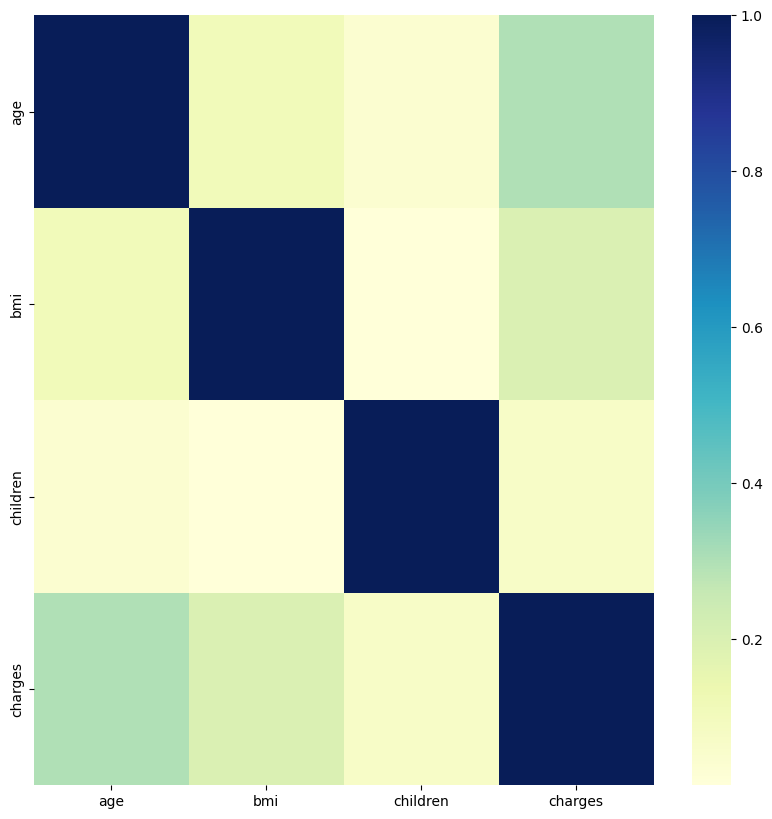

In [6]:
# Plot correlation between features and target
plt.figure(figsize=(10,10))
sns.heatmap(df_numerical.corr(), cmap="YlGnBu", annot=False)
#plt.savefig("Images/NumericalFeatures_vs_InsuranceCost_Correlation.png")

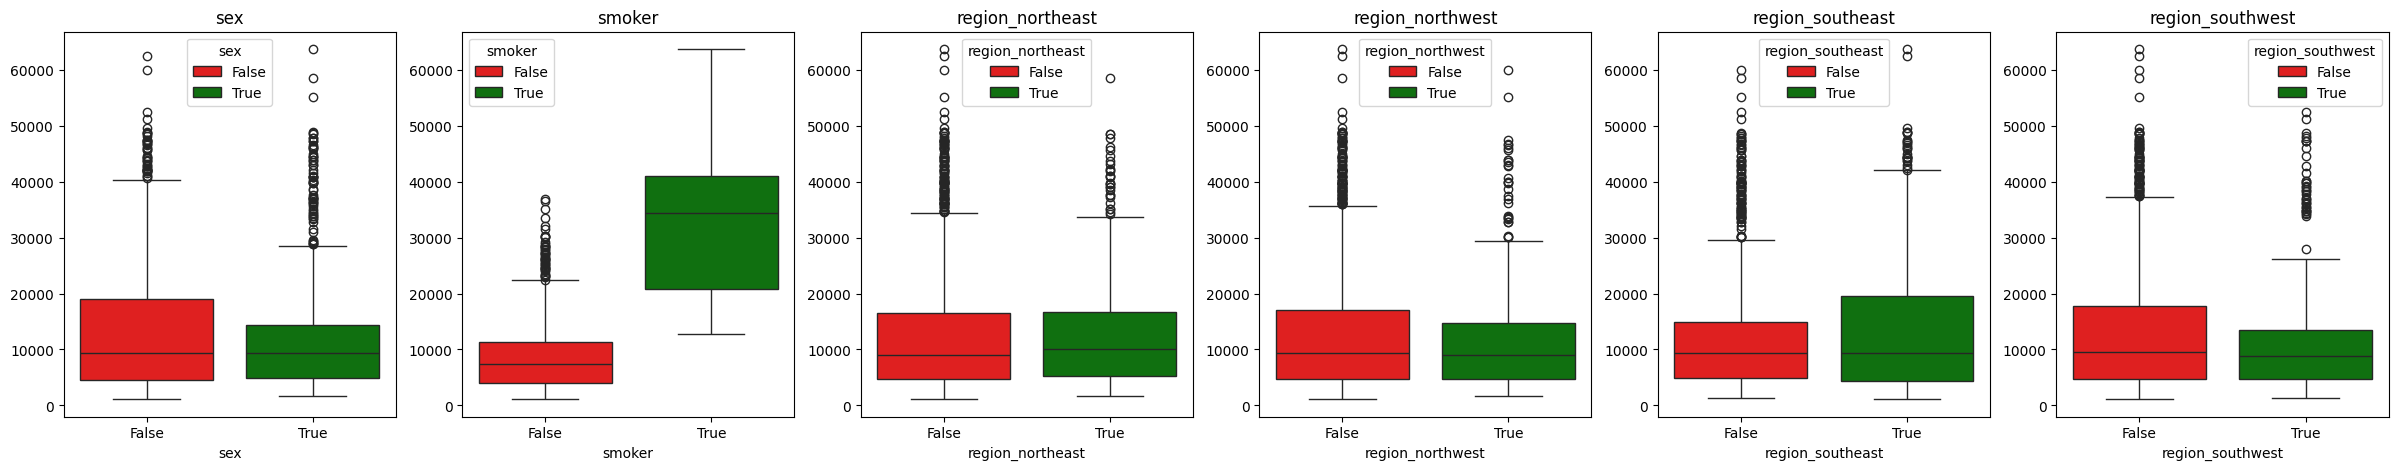

In [7]:
f, axes = plt.subplots(1, len(df_categorical.columns)-1, figsize=(30, 5))
for idx, feature_name in enumerate(df_categorical.columns):
    if feature_name != "charges":
        g = sns.boxplot(data=df_categorical, x=feature_name, y="charges", hue=feature_name, palette=['r','g'], ax=axes[idx])
        g.set(ylabel=None, title= feature_name);

#plt.savefig("Images/CategoricalFeatures_vs_InsuranceCost_BoxPlot.png")

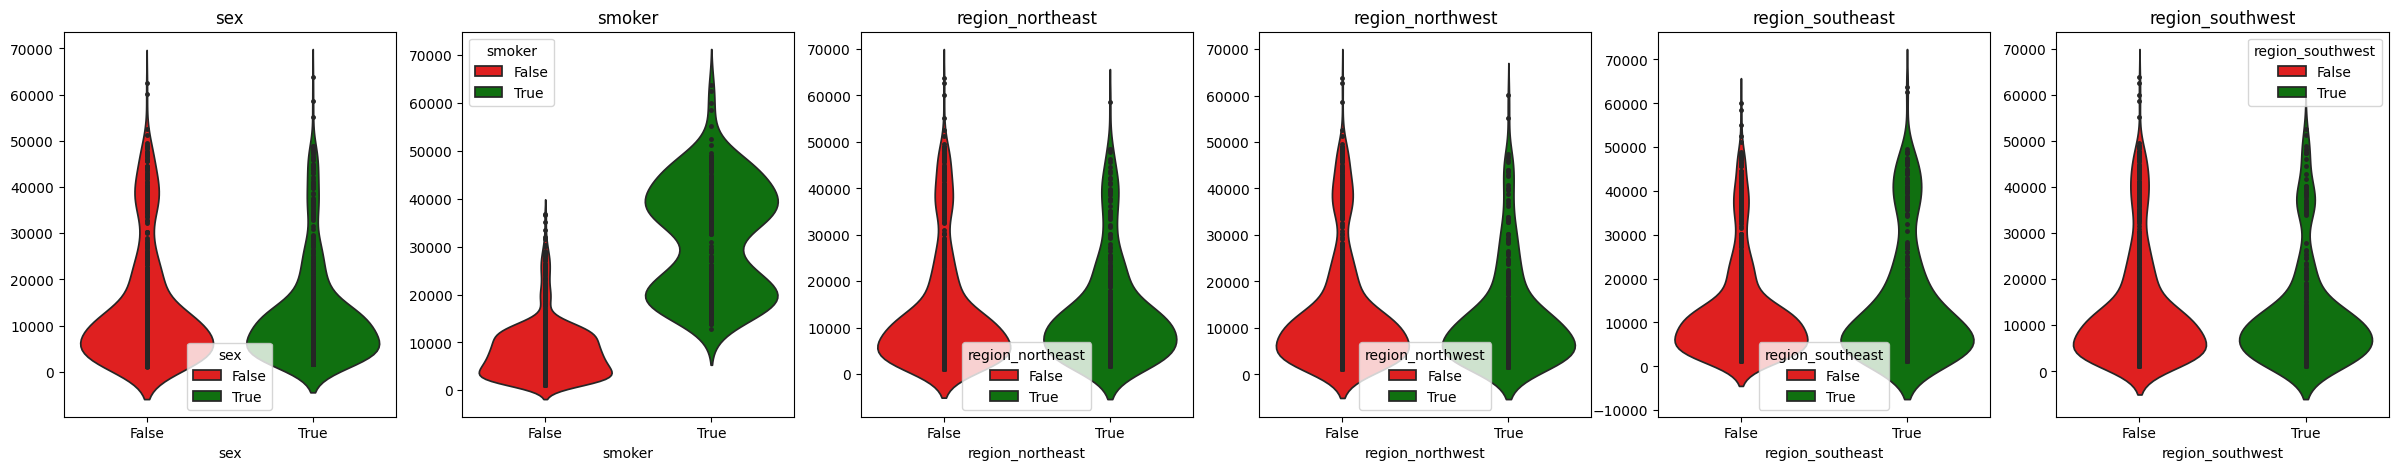

In [8]:
f, axes = plt.subplots(1, len(df_categorical.columns)-1, figsize=(30, 5))
for idx, feature_name in enumerate(df_categorical.columns):
    if feature_name != "charges":
        g = sns.violinplot(data=df_categorical, x=feature_name, y="charges", inner="points", hue=feature_name, palette=['r','g'],ax=axes[idx])
        g.set(ylabel=None, title= feature_name);

#plt.savefig("Images/CategoricalFeatures_vs_InsuranceCost_ViolinPlot.png")

# Prepare data to be fed as input to regression models

In [9]:
# Get numerical and categorical dataframes without the target
x_numerical = df_numerical.drop(columns=['charges'], inplace=False)
x_categorical = df_categorical.drop(columns=['charges'], inplace=False)
y =  df_numerical[['charges']].values.ravel()

# Scale numerical data and stack all X data
StandardScaler().fit_transform(x_numerical.values)
X = np.hstack((StandardScaler().fit_transform(x_numerical.values), x_categorical.values))

# Partition the data

Text(0.5, 1.0, 'Nr. Samples')

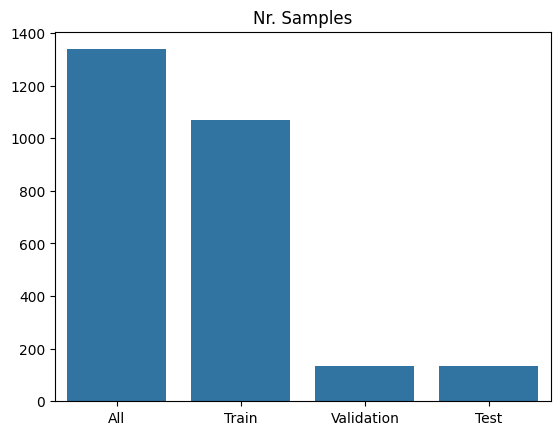

In [10]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=0)
X_train_valid = np.concatenate([X_train,X_valid])
y_train_valid = np.concatenate([y_train,y_valid])
sns.barplot(x=["All","Train","Validation","Test"], y=[X.shape[0], X_train.shape[0], X_valid.shape[0], X_test.shape[0]])
plt.title("Nr. Samples")

# Define objective funcions for hyperparameter tuning

In [11]:
# Objective function for hyperparameter tuning of DecisionTree
random_state = 42
def objective_dtr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "splitter": trial.suggest_categorical("splitter", ["best", "random"]),
    "max_depth": trial.suggest_int("max_depth", 1, 20),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),    
    "random_state": trial.suggest_categorical("random_state", [42]),
    }
    
    model = DecisionTreeRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [12]:
# Objective function for hyperparameter tuning of RandomForest
random_state = 42
def objective_rfr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
    "random_state": trial.suggest_categorical("random_state", [42]),
    "n_jobs": trial.suggest_categorical("n_jobs", [-1]),
    }
    
    model = RandomForestRegressor(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

In [13]:
# Objective function for hyperparameter tuning of Support Vector Machine
def objective_svr(trial, X_train, X_valid, y_train, y_valid):
    params = {
    "C": trial.suggest_float("C", 1e-10, 1e10, log=True),
    "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
    "max_iter": trial.suggest_categorical("max_iter", [10*1000*1000]),
    }
    
    model = SVR(**params).fit(X_train, y_train)
    r2 = model.score(X_valid, y_valid)
    #y_predicted = model.predict(X_valid)
    #rmse = mean_squared_error(y_valid, y_predicted, squared=False)
    
    return r2

# Train and test the regression models

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# DecisionTreeRegressor
study_dtr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_dtr(trial, X_train, X_valid, y_train, y_valid)
study_dtr.optimize(func, n_trials = 100, timeout=600)
model = DecisionTreeRegressor(**study_dtr.best_trial.params).fit(X_train_valid, y_train_valid)
dectree_r2 = model.score(X_test, y_test)

# RandomForestRegressor
study_rfr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_rfr(trial, X_train, X_valid, y_train, y_valid)
study_rfr.optimize(func, n_trials = 100, timeout=600)
model = RandomForestRegressor(**study_rfr.best_trial.params).fit(X_train_valid, y_train_valid)
randfor_r2 = model.score(X_test, y_test)

# SVR
study_svr = optuna.create_study(direction = "maximize")
func = lambda trial: objective_svr(trial, X_train, X_valid, y_train, y_valid)
study_svr.optimize(func, n_trials = 100, timeout=600)
model = SVR(**study_svr.best_trial.params).fit(X_train_valid, y_train_valid)
svr_r2 = model.score(X_test, y_test)

In [15]:
print("DecisionTreeRegressor R2 =", dectree_r2)
print("RandomForestRegressor Tree R2 =", randfor_r2)
print("SVR R2 =", svr_r2)

DecisionTreeRegressor R2 = 0.7544560103295374
RandomForestRegressor Tree R2 = 0.8428121751199585
SVR R2 = 0.8226190796917483


In [16]:
# Parameters for ANNs

hidden_num_nodes = X_train.shape[1]*2
# Integer or None. Number of samples per gradient update
batch_size = 8
# Number of epochs to train the model. 
# An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None).
nr_epochs = 150

# Regression with a simple ANN

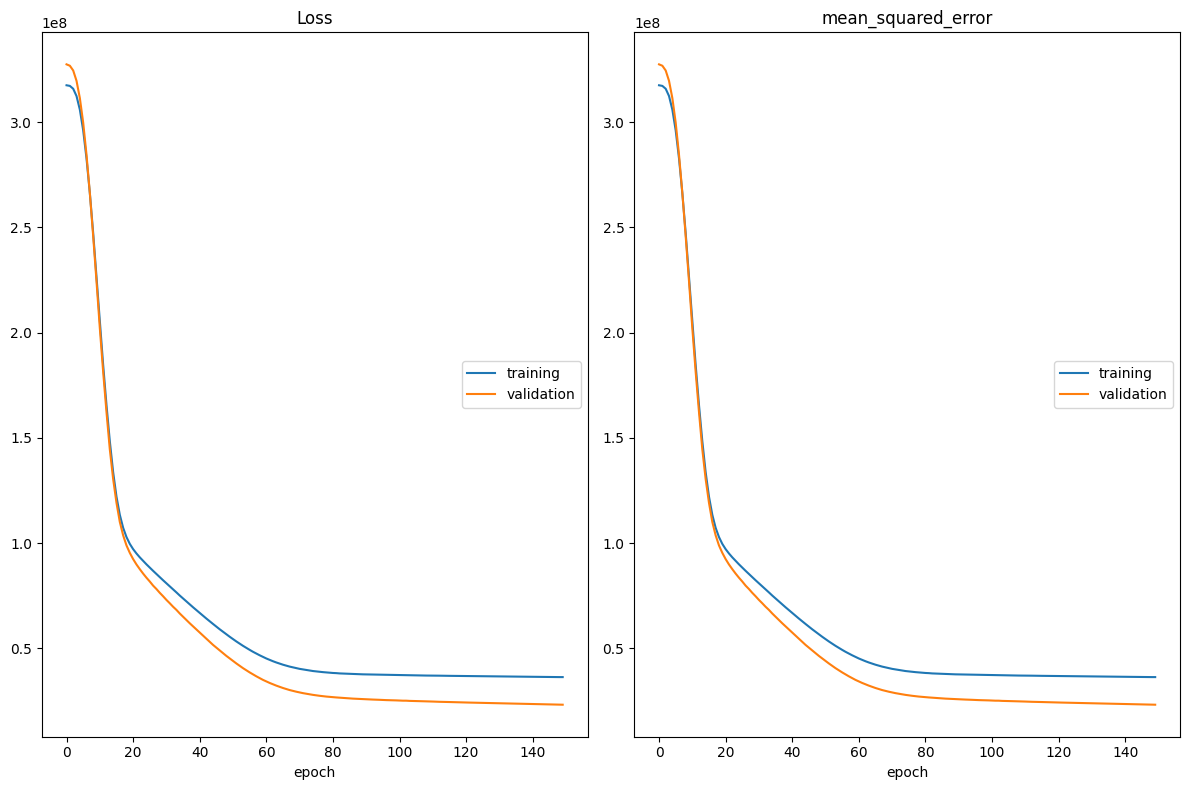

Loss
	training         	 (min: 36266084.000, max: 317608000.000, cur: 36266084.000)
	validation       	 (min: 23140550.000, max: 327553664.000, cur: 23140550.000)
mean_squared_error
	training         	 (min: 36266084.000, max: 317608000.000, cur: 36266084.000)
	validation       	 (min: 23140550.000, max: 327553664.000, cur: 23140550.000)


In [17]:
simple_ann_reg = Sequential()

# Optional
input_layer = Input(shape=(X_train.shape[1]))
simple_ann_reg.add(input_layer)

#Adding Hidden Layer
simple_ann_reg.add(Dense(units=hidden_num_nodes, activation='relu'))
#Adding Hidden Layer
simple_ann_reg.add(Dense(units=hidden_num_nodes, activation='relu'))
#Adding Output Layer
simple_ann_reg.add(Dense(units=1,activation='relu'))

# Compile the Network
simple_ann_reg.compile(optimizer = 'adam',
             loss = "mean_squared_error",
             metrics = ['mean_squared_error',])

# Train and monitor the model
simple_ann_reg.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [18]:
predictionsANNK = simple_ann_reg.predict(X_test)
test_r2 = r2_score(y_test, predictionsANNK)
print("R2 from the simple ANN: ", test_r2)

5/5 [==============================] - 0s 2ms/step
R2 from the simple ANN:  0.771253333285595


# Train and test the Keras ANN regressor model

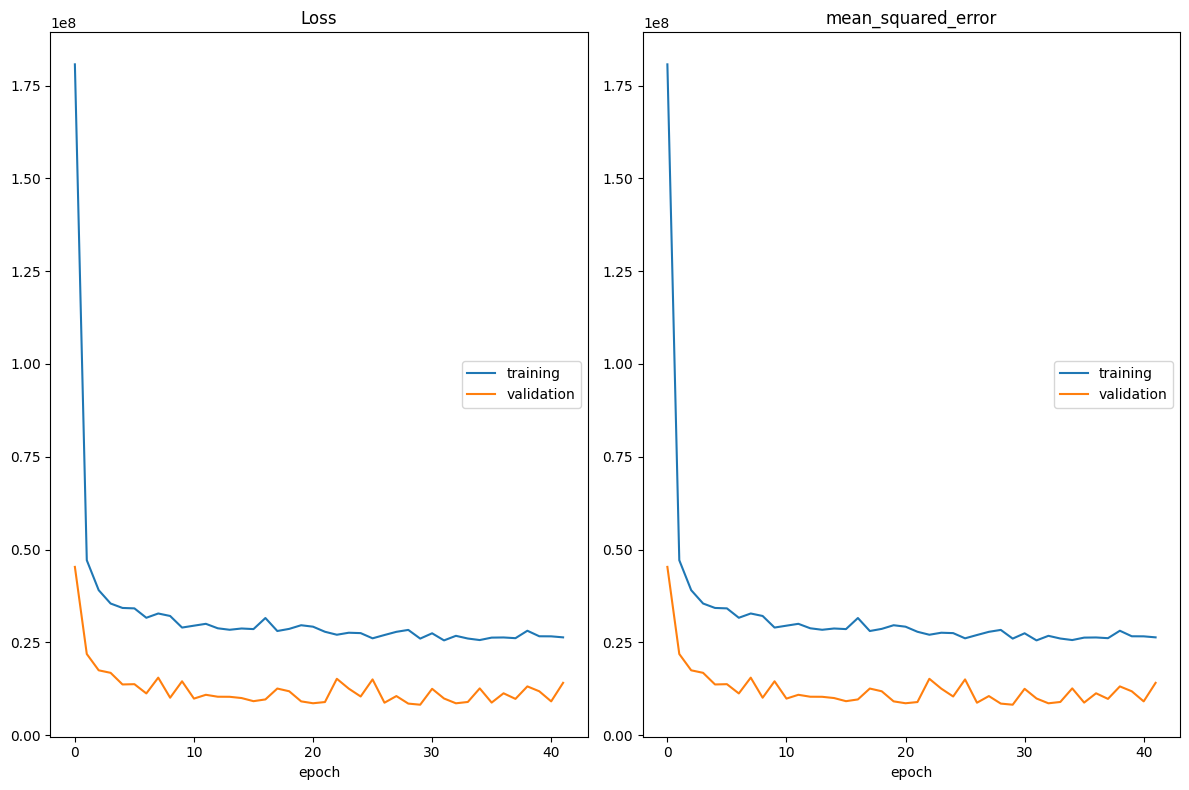

Loss
	training         	 (min: 25557186.000, max: 180704576.000, cur: 26375350.000)
	validation       	 (min: 8235922.000, max: 45353316.000, cur: 14125730.000)
mean_squared_error
	training         	 (min: 25557186.000, max: 180704576.000, cur: 26375350.000)
	validation       	 (min: 8235922.000, max: 45353316.000, cur: 14125730.000)
5/5 [==============================] - 0s 2ms/step

Root Mean Square Error
Training RMSE = 4632.035603478905
Test RMSE = 5203.552849446097

R2 Score
Training R^2 = 0.8522324980588942
Test R^2 = 0.8283848073834919


In [19]:
model = Sequential()

input_layer = Input(shape=(X_train.shape[1]))
model.add(input_layer)

activ_func_name = 'leaky_relu' # 'relu', 'elu', 'leaky_relu', 'linear'
nr_layers = 5
drop_out=True
hidden_num_nodes = X_train.shape[1]*20

for _ in range(nr_layers):
    model.add(Dense(hidden_num_nodes))
    model.add(Activation(activ_func_name))
    if drop_out:
        model.add(Dropout(0.25))

# Output layer
model.add(Dense(1))
model.add(Activation('linear'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

es_callback = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=10)
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=nr_epochs,
          validation_data=(X_valid, y_valid),
          callbacks=[es_callback, PlotLossesKeras()],
          verbose=0)

y_predicted_train = model.predict(X_train_valid)
train_mse = mean_squared_error(y_train_valid, y_predicted_train)
train_r2 = r2_score(y_train_valid, y_predicted_train)

y_predicted_test = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_predicted_test)
test_r2 = r2_score(y_test, y_predicted_test)

print("\nRoot Mean Square Error")
print("Training RMSE =", np.sqrt(train_mse))
print("Test RMSE =", np.sqrt(test_mse))

print("\nR2 Score")
print("Training R^2 =", train_r2)
print("Test R^2 =", test_r2)